# BBC News classification problem
Our goal is to classify the headline's topic based on the data we have been given. We use the nltk library and any other relevant tools to do this.

In [1]:
import tensorflow as tf
import pandas as pd
import nltk
from sklearn.metrics import accuracy_score,recall_score,precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read and preview data
bbc_data=pd.read_csv('bbc-text-1.csv')
bbc_data.head(5)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Exploratory Data Analysis and Visualisation

Text(0.5, 1.0, 'Categorised articles')

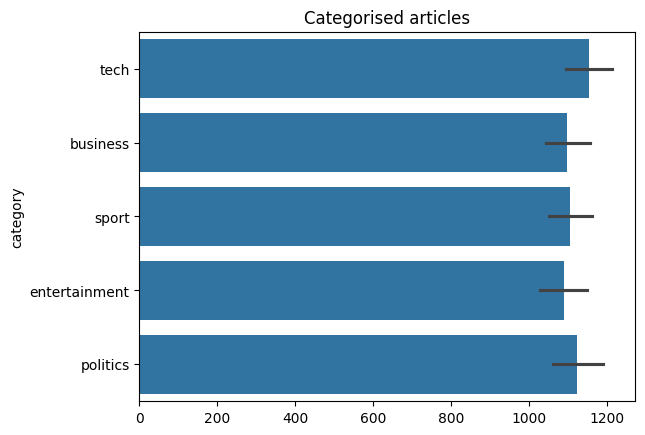

In [3]:
#assess if data is balanced
sns.barplot(bbc_data['category'])
plt.title('Categorised articles')

The data is clearly balanced. This means no further techniques are required to account for the biases in unbalanced data

## Data preprocessing
We want to reduce noise by removing stopwords and lemmatising the remaining words so when we apply techniques like tfidf, we don't return meaningless classifications.

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords data if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamchoong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adamchoong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/adamchoong/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### TFIDF preprocessing
We find if a causal relation or correlation exists between the results of completing a TFIDF operation on each string and their outcome during training.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]+\b',
    max_df=0.85,
    min_df=0.05,           
    max_features=300,
    ngram_range=(1, 2)       # Use unigrams and bigrams (1-grams and 2-grams)
)
tfidf_matrix = vectorizer.fit_transform(bbc_data['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,able,access,according,action,added,ago,ahead,american,analysts,announced,...,win,winning,won,work,working,world,year,year old,year s,years
0,0.0,0.0,0.047698,0.0,0.038668,0.0000,0.0,0.0,0.000000,0.055418,...,0.000000,0.000000,0.0,0.044812,0.0,0.0,0.000000,0.0,0.0,0.072374
1,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.1764,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.089115,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.142547,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.167049,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.000000,0.0,0.040458,0.0000,0.0,0.0,0.058233,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2221,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.181444,0.0,0.0,0.000000
2222,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.324057,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2223,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


## Proposed method: Supervised learning on NLTK
We will split the data 70/30. Our feature variable(s) will be the sparse matrix from the tfidf matrix. Since we know the data is sparse, decision trees and other algorithms that are prone to overfitting to noise will not be preferred.

In [6]:
from sklearn.model_selection import train_test_split
X,y=tfidf_df,bbc_data['category']
#repeat training and testing for average performance report
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def repeat_training_with_clf_report(model, X, y, n_repeats=10, test_size=0.3, random_states=None, target_names=None):
    """
    Repeats model training and testing, calculates average of all metrics, 
    and computes per-class accuracy.

    Parameters:
        model: scikit-learn compatible estimator
            The machine learning model to train.
        X: array-like or sparse matrix, shape (n_samples, n_features)
            Feature matrix.
        y: array-like, shape (n_samples,)
            Target vector.
        n_repeats: int, default=10
            Number of repetitions with different train-test splits.
        test_size: float, default=0.2
            Proportion of the dataset to include in the test split.
        random_states: list or None, default=None
            List of random states for reproducibility. If None, random states are generated.
        target_names: list of str or None, default=None
            List of class names for the classification report.

    Returns:
        avg_report: dict
            Classification report containing average metrics across repetitions
            including per-class accuracy.
    """
    if random_states is None:
        random_states = np.random.randint(0, 10000, size=n_repeats)
    
    reports = []
    
    for state in random_states:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=state)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on test data
        y_pred = model.predict(X_test)
        
        # Get classification report as a dictionary
        report = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True, target_names=target_names)
        reports.append(report)
    
    # Average the metrics across all iterations
    avg_report = {}
    for label in reports[0].keys():
        if label == "accuracy":  # Handle special case for accuracy
            continue  # Accuracy won't be averaged like other metrics
        avg_report[label] = {}
        for metric in reports[0][label].keys():
            avg_report[label][metric] = np.mean([rep[label][metric] for rep in reports])
      
    
    return avg_report

### Multinomial logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression


log_model = LogisticRegression(
    multi_class='multinomial',
    solver='saga',
    penalty='l1', 
    C=1.0,         # Regularization strength
    max_iter=1000
)
output=repeat_training_with_clf_report(log_model, X, y, n_repeats=10, test_size=0.2, random_states=None, target_names=None)
report_df=pd.DataFrame(output).transpose()
report_df

,precision,recall,f1-score,support
business,0.924932,0.918590,0.921450,98.6
entertainment,0.934665,0.899777,0.916289,77.2
politics,0.926888,0.936099,0.930875,83.2
sport,0.935972,0.985076,0.959665,103.1
tech,0.930231,0.892932,0.910729,82.9
macro avg,0.930537,0.926495,0.927801,445.0
weighted avg,0.930428,0.929663,0.929356,445.0


               precision    recall  f1-score   support

     business       0.89      0.91      0.90       164
entertainment       0.91      0.95      0.93       113
     politics       0.89      0.91      0.90       113
        sport       0.96      0.97      0.97       146
         tech       0.95      0.86      0.90       132

     accuracy                           0.92       668
    macro avg       0.92      0.92      0.92       668
 weighted avg       0.92      0.92      0.92       668



Text(0.5, 1.0, 'Multinomial Logistic Regression confusion matrix')

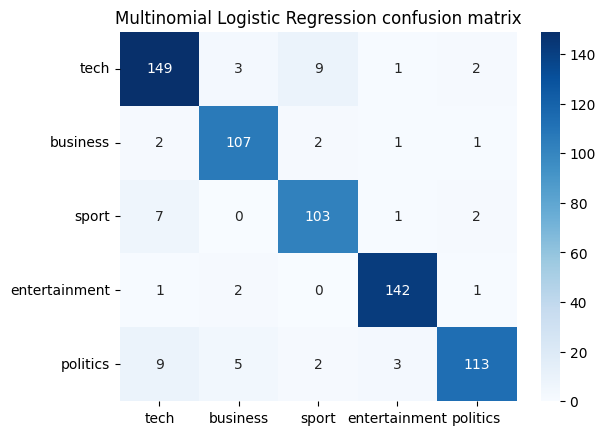

In [8]:
#plotting confusion matrix for reference
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3)
log_model.fit(X_train,y_train)
y_pred=log_model.predict(X_test)
cnf_mat=confusion_matrix(y_test,y_pred)
print(classification_report(y_pred=y_pred,y_true=y_test))
sns.heatmap(cnf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=bbc_data['category'].unique(), yticklabels=bbc_data['category'].unique())
plt.title('Multinomial Logistic Regression confusion matrix')

### SVM classifier

Let's see if we can improve our performance further using a linear kernel SVM. We don't want to use any other kernels like rbf because of the sparsity of the data that would make the model sensitive to errors and computationally inefficient.

In [9]:
from sklearn.svm import SVC

# Multiclass SVM
svm_model = SVC(kernel='linear', decision_function_shape='ovr',C=10)#use linear classifier for spare data

output=repeat_training_with_clf_report(svm_model, X, y, n_repeats=10, test_size=0.2, random_states=None, target_names=None)
report_df=pd.DataFrame(output).transpose()
report_df


,precision,recall,f1-score,support
business,0.907930,0.926559,0.916688,104.4
entertainment,0.895406,0.927010,0.910377,77.5
politics,0.934541,0.930045,0.932136,86.2
sport,0.971877,0.963580,0.967610,101.5
tech,0.949376,0.906363,0.926793,75.4
macro avg,0.931826,0.930711,0.930721,445.0
weighted avg,0.933453,0.932135,0.932289,445.0


               precision    recall  f1-score   support

     business       0.93      0.91      0.92       164
entertainment       0.90      0.92      0.91       113
     politics       0.90      0.94      0.92       113
        sport       0.97      0.97      0.97       146
         tech       0.96      0.94      0.95       132

     accuracy                           0.94       668
    macro avg       0.93      0.94      0.93       668
 weighted avg       0.94      0.94      0.94       668



Text(0.5, 1.0, 'SVM confusion matrix')

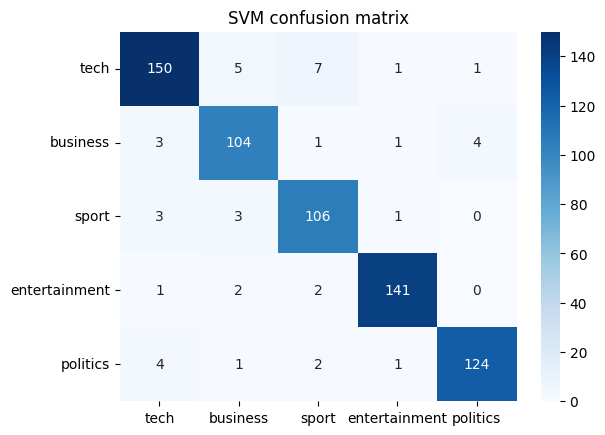

In [10]:
#plotting confusion matrix for reference
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3)
svm_model.fit(X_train,y_train)
y_pred=svm_model.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
cnf_mat=confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=bbc_data['category'].unique(), yticklabels=bbc_data['category'].unique())
plt.title('SVM confusion matrix')

This model in the given configurations performs slightly better. Let's see if we can improve further by using XGB

### XGB Boost

We use a final supervised technique. It is a variant of decision trees that performs well on sparse data.

/Users/adamchoong/miniconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

           0       0.92      0.92      0.92       164
           1       0.95      0.92      0.94       113
           2       0.89      0.95      0.92       113
           3       0.97      0.99      0.98       146
           4       0.96      0.90      0.93       132

    accuracy                           0.94       668
   macro avg       0.94      0.94      0.94       668
weighted avg       0.94      0.94      0.94       668



Text(0.5, 1.0, 'XGB confusion matrix')

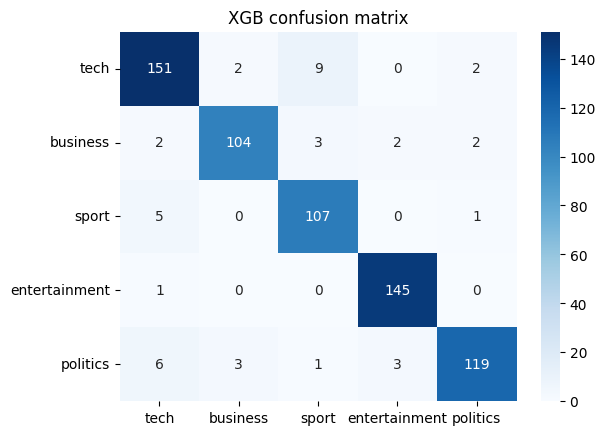

In [13]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
params = {
    'objective': 'multi:softmax',  
    'num_class': 5, 
    'max_depth': 5,  
    'learning_rate': 0.1,  
    'eval_metric': 'mlogloss'  
} 
# Label Encoding for target labels (if y is a string, use LabelEncoder)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_model=XGBClassifier(params)
# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test set
y_pred = bst.predict(dtest)
print(classification_report(y_test,y_pred))
cnf_mat=confusion_matrix(y_test,y_pred)
sns.heatmap(cnf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=bbc_data['category'].unique(), yticklabels=bbc_data['category'].unique())
plt.title('XGB confusion matrix')

It is possible for each model to achieve similar performances under the same conditions when considering accuracy as the only main metric. We recommend using simple models that are highly interpretable yet high performing. Multinomial logistic regression performs sufficiently but may not meet the desired level of accuracy. Therefore, we recommend SVM as the accurcy is closer to the benchmark 95% and interpretability of the model is maintained.

## Suggested improvements
We can explore a wider scope of models and hyperparameters through cross-validation or using clustering to group similar articles together. However, cross-validation would require additional computational resources and time, and clustering might not be suitable for this specific dataset due to the sparsity of the text data. Clustering is not supervised too, which makes it difficult to assess and compare with other models. 